In [1]:
import tensorflow as tf
#import tensorflow_probability as tfp
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
import pandas as pd

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.0.0


$\frac{\partial p(x,t)}{\partial t} = \frac{\partial}{\partial x}\left[\frac{m\omega^2}{\gamma} x \,p(x,t) + D \frac{\partial p(x,t)}{\partial x}\right] \qquad A= \frac{m\omega^2}{\gamma}= \frac{k}{\gamma}$ 

In [2]:
import pickle
real = pickle.load(open('./simulations/numerical_solution.sav', 'rb'))

# *Data Prep*

Training and Testing data is prepared from the solution file

In [3]:
from scipy.stats import norm
from scipy import constants

Temperature= 300 # K
viscosity=1e-3 # Kg / (m * s) 
radius=20e-10 # m
gamma=6*np.pi*viscosity*radius # Kg / s
k= 3e-7 # Kg / s^2; 10GHz for frequency and 3e-26 Kg for mass
A= k/gamma # s ^ -1
D= Temperature*constants.k / gamma # m^2 / s
"""
print(f"{gamma = } [Kg/s]")
print(f"{k = } [Kg/s^2]")
print(f"kB = {constants.k} [J/K]")
print(f"{A = } [s^-1], {D = } [m^2/s]")
"""

# Change of units m -> µm
#                 s -> ms
# such that A ~ O(1), D ~ O(0.1)
A = A * 1e-3 # s^-1 -> ms^-1 
D = D * 1e-3 * 1e+12 # m^2/s -> µm^2/ms
#collocation points for every position and every time
x_lower = -0.1
x_upper = 0.25
N_x= 350
dx = (x_upper - x_lower) / N_x
x = np.linspace(x_lower, x_upper, N_x) # µm line
t_lower = 0
t_upper = 2 * D # Typical time is D
N_steps=200
t = np.linspace(t_lower, t_upper, N_steps) # ms interval
X, T = np.meshgrid(x,t)
# Initial Condition
psol=np.zeros((len(x),len(t)))
psol[:,0]=real[0]
#print(f"{A = } [ms^-1], {D = } [µm^2/ms]")

maxiter = 25000

# *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

In [4]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_p_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Domain bounds
low_bound = np.array([x_lower, t_lower]) 
up_bound = np.array([x_upper, t_upper])

'''
stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
p = psol.flatten('F')

In [5]:
def trainingdata(N_bc, N_ic, N_f):
    """ Initial Condition"""

    #Initial Condition -1 =< x =<1 and t = 0  
    all_ic_x = np.vstack((X[0,:], T[0,:])).T
    all_ic_p = psol[:,0].reshape(len(psol[:,0]),1)
     
    '''Boundary Conditions'''

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.vstack((X[:,0], T[:,0])).T
    bottomedge_p = psol[-1,:].reshape(len(psol[-1,:]),1)

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.vstack((X[:,-1], T[:,0])).T
    topedge_p = psol[0,:].reshape(len(psol[0,:]),1)


    all_bc_x=np.vstack([bottomedge_x, topedge_x])
    # Reflecting conditions do not use the value of p
    #all_bc_p_train = np.vstack([ bottomedge_p, topedge_p])  

    #choose random N_bc and N:ic points for training
    index_bc = np.random.choice(all_bc_x.shape[0], N_bc, replace=False) 
    index_ic = np.random.choice(all_ic_x.shape[0], N_ic, replace=False)

    x_bc_train = all_bc_x[index_bc, :] 
    x_ic_train = all_ic_x[index_ic, :] 
    p_ic_train = all_ic_p[index_ic,:]    

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x_f_train = low_bound + (up_bound-low_bound)*lhs(2,N_f)
 
    #x_f_train = np.vstack((x_f_train, x_bc_train, x_ic_train))

    '''Normalization Instants'''
    x_norm_instant = np.vstack((X[100,:],
                                T[100,:])).T
    
    return x_f_train, x_bc_train, x_ic_train, p_ic_train, x_norm_instant


# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [6]:
extra_features = ["xLower-0.1","xUpper0.25","micrometers_miliseconds","k1e-7","r1e-20"]
print("Training with extra features:", extra_features)
additional_constraints = []
print("Training with extra constraints:", additional_constraints)


def save_train_history(NN):
    TRAIN_HISTORY = NN.get_training_history()
    data_filename = "./data/TRAIN_HISTORY_"
    if len(additional_constraints) != 0:
        for constrain in additional_constraints:
            data_filename = data_filename + constrain + "_"
    data_filename = data_filename + f"IC{N_ic}_BC{N_bc}_f{N_f}_t{t_upper}_iter{maxiter}"
    if len(extra_features) != 0:
        for feat in extra_features:
            data_filename = data_filename + "_" + feat
    print("Saving", data_filename, "...")
    pd.DataFrame(TRAIN_HISTORY).to_csv(data_filename + ".csv")

def save_model_weights(NN):
    model_filename = "./models/MODEL_WEIGHTS_"
    if len(additional_constraints) != 0:
        for constrain in additional_constraints:
            model_filename = model_filename + constrain + "_"
    model_filename = model_filename + f"IC{N_ic}_BC{N_bc}_f{N_f}_t{t_upper}_iter{maxiter}"
    if len(extra_features) != 0:
        for feat in extra_features:
            model_filename = model_filename + "_" + feat
    print("Saving", model_filename, "...")
    np.savetxt(model_filename + ".txt", NN.get_weights().numpy())

Training with extra features: ['xLower-0.1', 'xUpper0.25', 'micrometers_miliseconds', 'k1e-7', 'r1e-20']
Training with extra constraints: []


In [7]:
class Sequentialmodel(tf.Module): 
    def __init__(self,
                 layers,
                 low_bound, up_bound,
                 x_ic_train, p_ic_train,
                 x_bc_train,
                 x_f_train,
                 x_norm_instants,
                 name = "FP-PINN",
                 A = 10,
                 D = 0.1,
                 doPrint = True,
                 additional_constraints = ()):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        self.epoch = 0
        self.doPrint = doPrint
        self.callback_after_n = 1000
        self.history = {"epoch": [],
                        "Total loss": [],
                        "IC loss": [],
                        "BC loss": [],
                        "f loss": [],
                        "Pr loss": [],
                        "Norm loss": [],
                        "Equi loss": []}


        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    
    def evaluate(self,x):
        
        x = (x-low_bound)/(up_bound-low_bound) # Normalization
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def set_training_history(self, path):
        history = pd.read_csv(path)
        self.history["epoch"] = list(history["epoch"])
        self.epoch = self.history["epoch"][-1]
        self.history["Total loss"] = list(history["Total loss"])
        self.history["IC loss"] = list(history["IC loss"])
        self.history["BC loss"] = list(history["BC loss"])
        self.history["f loss"] = list(history["f loss"])
        self.history["Pr loss"] = list(history["Pr loss"])
        self.history["Norm loss"] = list(history["Norm loss"])
        self.history["Equi loss"] = list(history["Equi loss"])

    def get_training_history(self):
        return self.history

    
    def set_epoch(self, epoch):
        self.epoch = epoch
        
    def get_epoch(self):
        return self.epoch


    # Satisfy the IC
    def loss_IC(self, ic_points, p_ic_train):
        return tf.reduce_mean(tf.square(p_ic_train - self.evaluate(ic_points))) # MSE_ic


    # Reflecting boundary
    def loss_BC(self, bc_points):
        variable_bc = tf.Variable(bc_points, dtype = 'float64', trainable = False)

        x_bc = variable_bc[:,0:1]
        t_bc = variable_bc[:,1:2]
        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_bc)
            tape.watch(t_bc)

            tensor_bc = tf.stack([x_bc[:,0], t_bc[:,0]], axis=1)   

            output_p_bc = self.evaluate(tensor_bc)
        p_x = tape.gradient(output_p_bc,x_bc)  #more efficient out of the context

        del tape

        J = -1 * (A * x_bc * output_p_bc + D * p_x)

        return tf.reduce_mean(tf.square(J)) # MSE_bc

    # Satisfy the PDE at the collocation points
    def loss_PDE(self, collocation_points):
    
        variable_collocation = tf.Variable(collocation_points, dtype = 'float64', trainable = False)

        x_f = variable_collocation[:,0:1]
        t_f = variable_collocation[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            tensor_collocation = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            output_p_collocation = self.evaluate(tensor_collocation)
            p_x = tape.gradient(output_p_collocation,x_f) #inside the context bc we need it for higher derivative
        p_t = tape.gradient(output_p_collocation,t_f)    
        p_xx = tape.gradient(p_x, x_f)  

        del tape

        f = p_t - A * output_p_collocation - A * x_f * p_x - D * p_xx

        return tf.reduce_mean(tf.square(f)) # MSE_f


    # Satisfy probabilty norm at some instants
    def loss_NORM(self, instants):
        o = self.evaluate(instants)
        return tf.abs(tf.reduce_sum(o) * dx - 1.0) # ME |norm - 1|

    # Must be Boltzmann at t >> 1 with ß * m * w ** 2 = A / D
    def loss_EQUI(self):
        # Typical time is ln(2) / A ≈ 0.69 / A
        t_large = 10 * (0.69 / A) * np.ones(256).reshape(256, 1)
        x_domain = np.linspace(low_bound[0], up_bound[0], 256).reshape(256, 1)
        x_at_large_t = tf.stack([x_domain[:,0], t_large[:,0]], axis=1)
        output = self.evaluate(x_at_large_t)
        boltzmann_dist = tf.exp(-1 * (A/(2*D)) * x_domain ** 2)
        z = tf.reduce_sum(boltzmann_dist) * dx
        boltzmann_dist = boltzmann_dist / z
        # L2 norm (Boltzmann_dist - output)
        return tf.reduce_mean(tf.square(boltzmann_dist - output) * dx)


    # Satisfy p > 0 at IC and the collocation points
    def loss_PROB(self, ic_points, collocation_points):
        o1 = self.evaluate(ic_points)
        o2 = self.evaluate(collocation_points)
        negatives = tf.where(tf.greater_equal(o1, 0.),
                             tf.zeros_like(o1),
                             o1)
        loss_pr = tf.abs(tf.reduce_mean(negatives)) # MSE (p < 0) at IC
        negatives = tf.where(tf.greater_equal(o2, 0.),
                             tf.zeros_like(o2),
                             o2)
        loss_pr = loss_pr + tf.abs(tf.reduce_mean(negatives)) # MSE (p < 0) at collocation
        return loss_pr


    def loss(self):
        loss_ic = self.loss_IC(x_ic_train, p_ic_train)
        loss_bc = self.loss_BC(x_bc_train)
        loss_f = self.loss_PDE(x_f_train)
        loss_prob = self.loss_PROB(x_ic_train, x_f_train)
        loss_norm = self.loss_NORM(x_norm_instants)
        loss_equi = self.loss_EQUI()
        loss = loss_ic + loss_bc + loss_f
        if "prob" in additional_constraints:
            loss = loss + loss_prob
        if "norm" in additional_constraints:
            loss = loss + loss_norm
        if "equi" in additional_constraints:
            loss = loss + loss_equi
        return loss, loss_ic, loss_bc, loss_f, loss_prob, loss_norm, loss_equi
    
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            total_loss, loss_ic, loss_bc, loss_f, loss_pr, loss_norm, loss_equi = self.loss()
            grads = tape.gradient(total_loss,self.trainable_variables)
        
        if self.doPrint:
            self.epoch += 1
            tf.print(f"epoch: {self.epoch}", f"- Total: {total_loss:5.4e}", f"IC: {loss_ic:5.4e}",
                     f"BC: {loss_bc:5.4e}", f"f: {loss_f:5.4e}", f"Norm: {loss_norm:5.4e}", f"equi: {loss_equi:5.4e}")
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        self.history["epoch"].append(self.epoch)
        self.history["Total loss"].append(float(total_loss))
        self.history["IC loss"].append(float(loss_ic))
        self.history["BC loss"].append(float(loss_bc))
        self.history["f loss"].append(float(loss_f))
        self.history["Pr loss"].append(float(loss_pr))
        self.history["Norm loss"].append(float(loss_norm))
        self.history["Equi loss"].append(float(loss_equi))

        return total_loss.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
        if self.epoch % self.callback_after_n == 0:
            save_train_history(self)
            save_model_weights(self)



# *Solution Plot*

In [16]:
def differenceplot(u_pred, real, X_u_train):
    
    fig, ax = plt.subplots(dpi=250)
    ax.axis('off')

    gs0 = gridspec.GridSpec(2, 3)
    gs0.update(top=1, bottom=0, left=0.1, right=2, wspace=0.3, hspace =0.4)
    ax = plt.subplot(gs0[0, :])
    rel_err = np.absolute(u_pred-real)/np.max(real)
    rel_err[rel_err > 1] = 1
    h = ax.imshow(rel_err, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
 
    #ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    #ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t(ms)$')
    ax.set_ylabel('$x(\mu m)$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$p(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    #gs1 = gridspec.GridSpec(1, 3)
    #gs1.update(top=0.3, bottom=-0.1, left=0.1, right=2, wspace=0.5)

    ax = plt.subplot(gs0[1, 0])
    #ax.plot(x,usol.T[0,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x, u_pred.T[0,:], 'r', linewidth = 2, label = 'Prediction')
    ax.plot(x, real.T[0,:], 'b', linewidth = 2, label = 'Real')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x,t)$')    
    ax.set_title('$t = 0.s$', fontsize = 10)
    #ax.axis('square')
    ax.set_xlim([x_lower ,x_upper])
    ax.set_ylim([0.0, 0.015])

    ax = plt.subplot(gs0[1, 1])
    #ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[int(0.15*len(t)),:], 'r', linewidth = 2, label = 'Prediction')
    ax.plot(x,real.T[int(0.15*len(t)),:], 'b', linewidth = 2, label = 'Real')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x,t)$')
    #ax.axis('square')
    ax.set_xlim([x_lower, x_upper])
    ax.set_ylim([0.0, 0.015])
    ax.set_title('$t = {}ms$'.format(int(0.5*len(t))/2000), fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs0[1, 2])
    #ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[int(0.75*len(t)),:], 'r', linewidth = 2, label = 'Prediction')
    ax.plot(x,real.T[int(0.75*len(t)),:], 'b', linewidth = 2, label = 'Real')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x,t)$')
    #ax.axis('square')
    ax.set_xlim([x_lower, x_upper])
    ax.set_ylim([0.0, 0.015])    
    ax.set_title('$t = {}ms$'.format(int(0.75*len(t))/2000), fontsize = 10)
    
    #plt.tight_layout()
    plt.savefig('Ornstein-Uhlenbeck.png',dpi = 500)   

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [ ]:
N_bc = 250 #Total number of boundary conditions points
N_ic = 250 #Total number of initial condition points
N_f = 1000 #Total number of collocation points

# Training data
x_f_train, x_bc_train, x_ic_train, p_ic_train, x_norm_instants = trainingdata(N_bc, N_ic, N_f)

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers, low_bound, up_bound,
                      x_ic_train, p_ic_train,
                      x_bc_train,
                      x_f_train,
                      x_norm_instants,
                      A=A,
                      D=D)

init_params = PINN.get_weights().numpy()
#init_params = np.loadtxt("./models/MODEL_WEIGHTS_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20.txt")
#PINN.set_weights(init_params)
#PINN.set_training_history("./data/TRAIN_HISTORY_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20.csv")


start_time = time.time() 
# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter': max(maxiter - PINN.get_epoch(), 0),
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
elapsed = time.time() - start_time
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


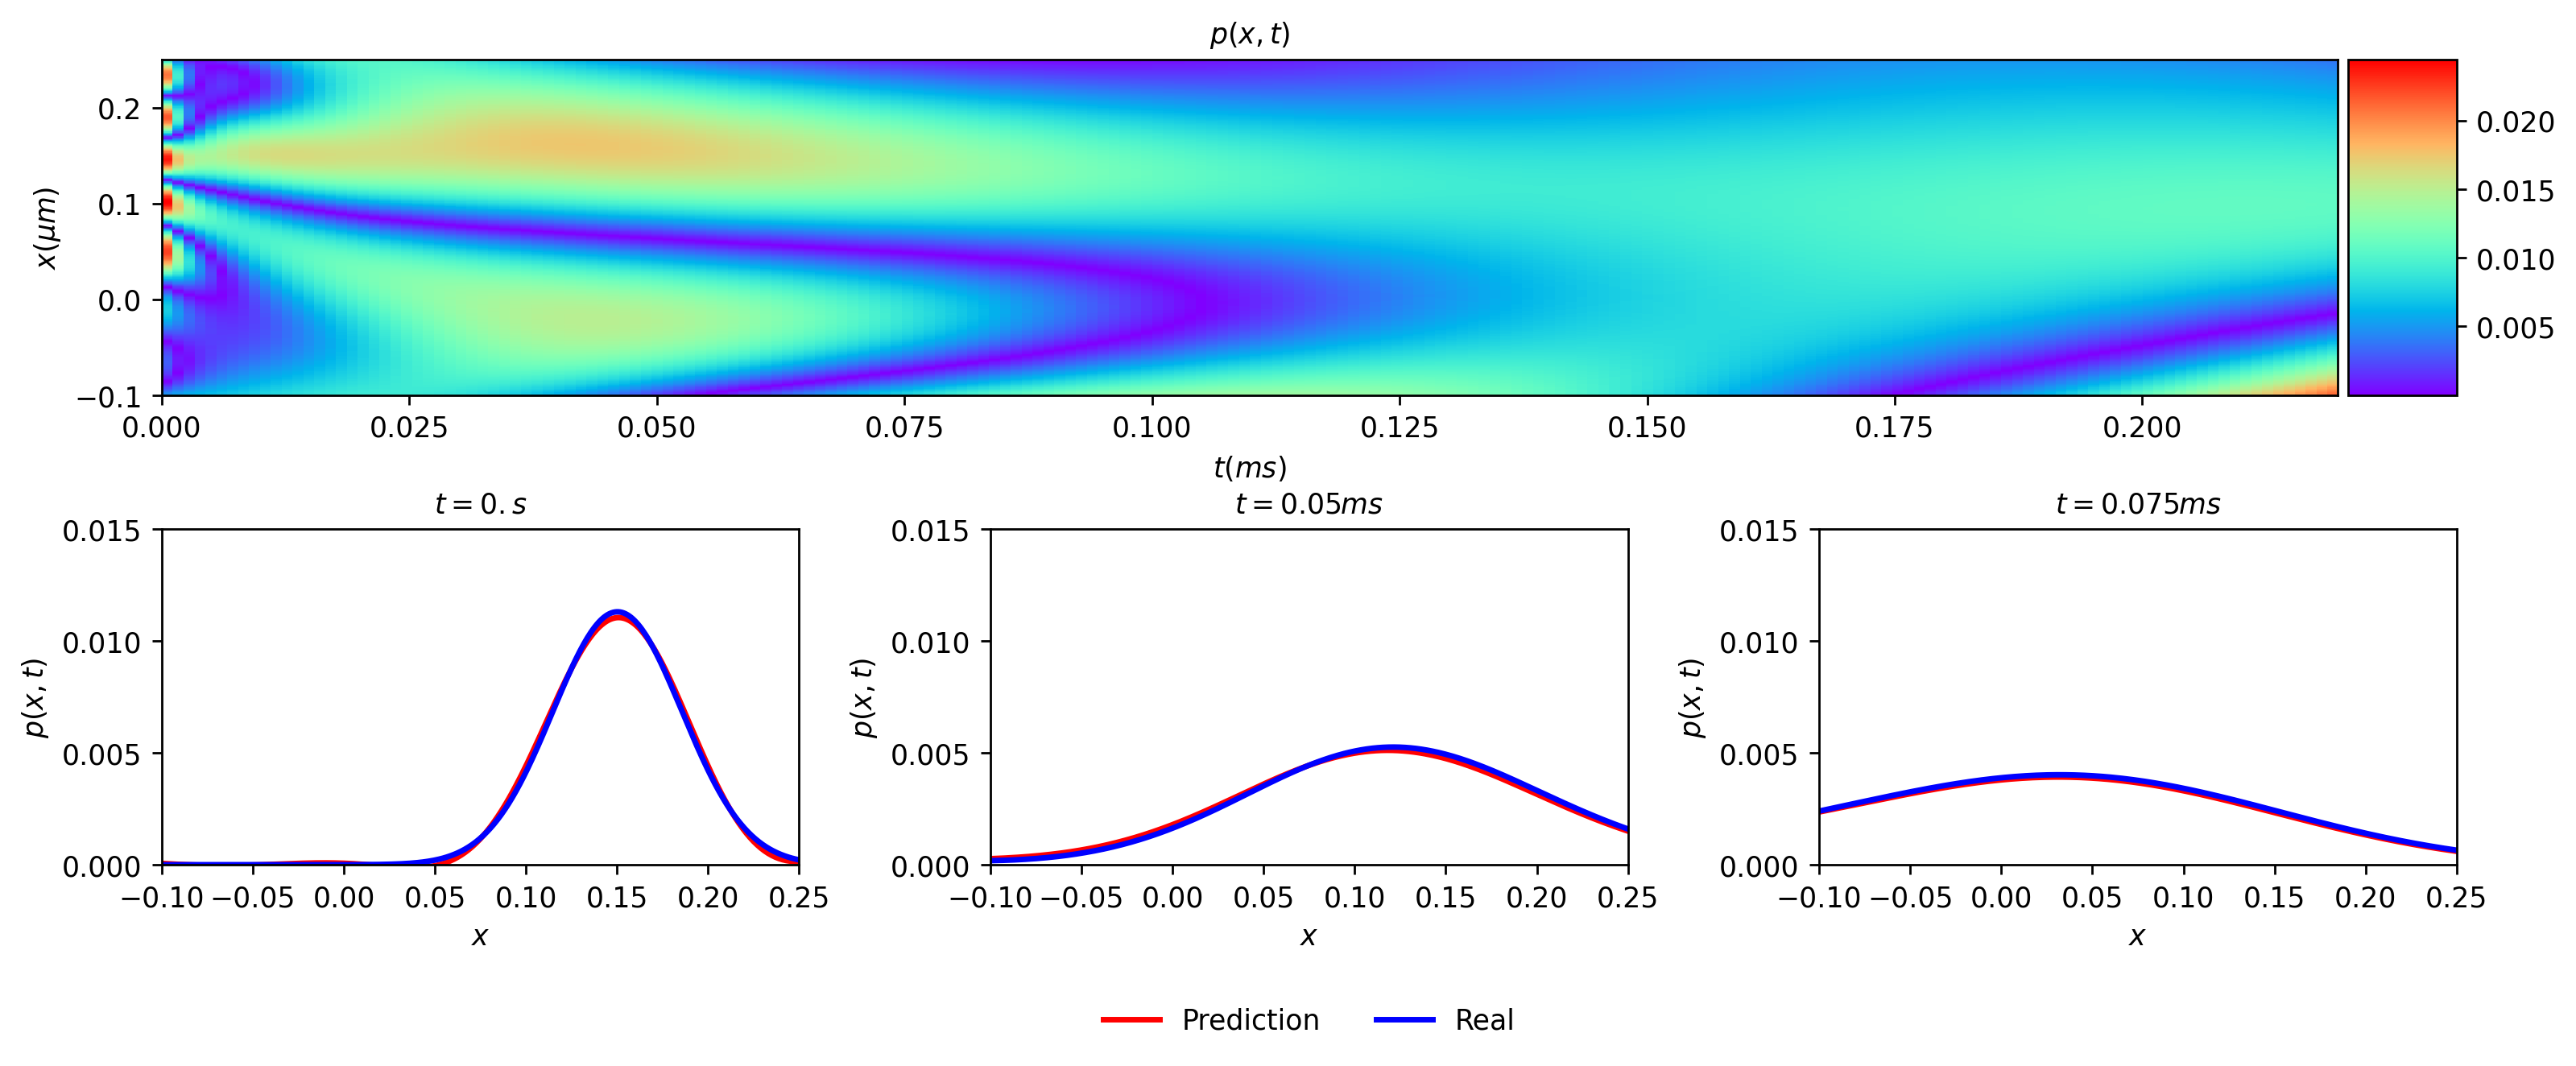

In [17]:
N_bc = 250 #Total number of boundary conditions points
N_ic = 250 #Total number of initial condition points
N_f = 1000 #Total number of collocation points

# Training data
x_f_train, x_bc_train, x_ic_train, p_ic_train, x_norm_instants = trainingdata(N_bc, N_ic, N_f)

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers, low_bound, up_bound,
                      x_ic_train, p_ic_train,
                      x_bc_train,
                      x_f_train,
                      x_norm_instants,
                      A=A,
                      D=D)
prev_weights = np.loadtxt("./models/MODEL_WEIGHTS_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20.txt")
PINN.set_weights(prev_weights)

p_pred = PINN.evaluate(X_p_test)
p_pred = np.reshape(p_pred,(N_x, N_steps),order='F')                        # Fortran Style ,stacked column wise!

''' Solution Plot '''
differenceplot(p_pred ,real.T ,X_p_test)

In [12]:
def solutionplot(p_pred,X_p_train):#,p_train):
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.05, bottom=1-1/3, left=0.1, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(p_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    #ax.plot(X_p_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    #line = np.linspace(x.min(), x.max(), 2)[:,None]
    #ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    
    ax.axvline(x=t_upper, color="red")

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$p(x,t)$', fontsize = 10)

    
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1/2, bottom=0.05, left=0.2, right=0.8, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    #ax.plot(x,usol.T[0,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,p_pred.T[0,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title(f'$t = {t[0]}s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([x_lower - 0.1 ,x_upper + 0.1])
    ax.set_ylim([0,1.0])

    ax = plt.subplot(gs1[0, 1])
    #ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,p_pred.T[50,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([x_lower - 0.1 ,x_upper + 0.1])
    ax.set_ylim([0,1.0])
    #ax.set_title(f'$t = {t[int(t/2)]}s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    #ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,p_pred.T[75,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x,t)$')
    ax.axis('square')
    ax.set_xlim([x_lower - 0.1 ,x_upper + 0.1])
    ax.set_ylim([0,1.0])    
    ax.set_title(f'$t = {t[-1]}s$', fontsize = 10)
    
    plt.tight_layout()
    #plt.savefig('Ornstein-Uhlenbeck.png',dpi = 500)
    

### Predictions

In [ ]:
N_bc = 100 #Total number of boundary conditions points
N_ic = 100 #Total number of initial condition points
N_f = 1000 #Total number of collocation points

# Training data
x_f_train, x_bc_train, x_ic_train, p_ic_train, x_norm_instants = trainingdata(N_bc, N_ic, N_f)

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers, low_bound, up_bound,
                      x_ic_train, p_ic_train,
                      x_bc_train,
                      x_f_train,
                      x_norm_instants,
                      A=A,
                      D=D)

init_params = np.loadtxt("/Users/max/Documents/Lab_b/PINNs-Review/src/OUR CODE/models/MODEL_WEIGHTS_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20.txt")
PINN.set_weights(init_params)
p_pred = PINN.evaluate(X_p_test)


p_pred = np.reshape(p_pred,(N_x,N_steps),order='F')
differenceplot(p_pred, real.T, X_p_test)

## A metric to test performances: KL-divergence
In order to quantify the distance in the space of probability density function we can use the KL-divergence and show how the distance between the PINN prediction and the numerical solution evolves in time.

In [10]:
def KL_divergence_over_time(prediction, numerical, t=t):
    #Recall prediction and numerical have shape (N_x,N_steps)
    KL=[]
    for i in range(len(t)):
        KL.append(np.dot(numerical[:,i], np.log(numerical[:,i]/prediction[:,i])))
    plt.figure(dpi=200)
    plt.plot(t,KL)
    plt.xlabel("t(ms)")
    plt.ylabel("$D(p_{num}||p_{pred})$")
    plt.legend()
    plt.show()
    return KL

/Users/alessiogiorlandino/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


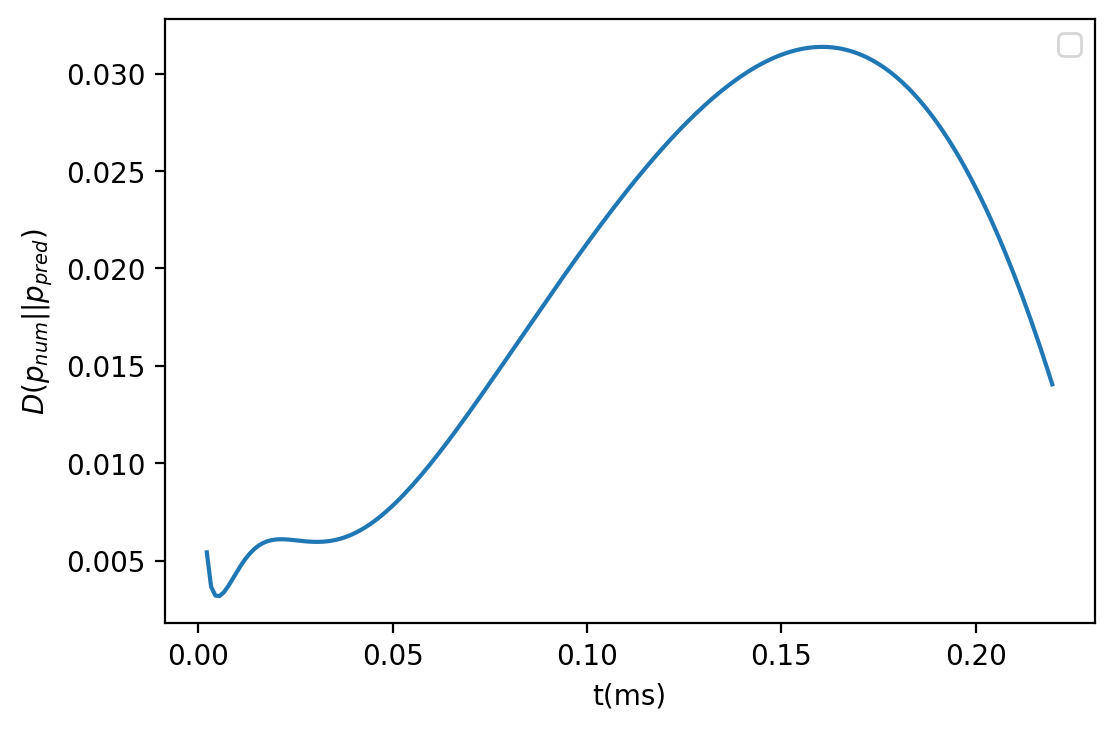

In [11]:
kl=KL_divergence_over_time(p_pred, real.T)

In [43]:
save_model_weights(PINN)
save_train_history(PINN)

Saving ./models/MODEL_WEIGHTS_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20 ...
Saving ./data/TRAIN_HISTORY_IC100_BC100_f1000_t0.2197371130248822_iter25000_xLower-0.1_xUpper0.25_micrometers_miliseconds_k1e-7_r1e-20 ...


In [ ]:
import pandas as pd
data_filename = # PUT PERTINENT TRAIN_HISTORY HERE
plt.style.use("dark_background")
plt.figure(figsize=(10,8))
plt.title("Training Loss")
df = pd.read_csv(data_filename)
plt.plot(df["epoch"], df["Total loss"], label="Total Loss")
plt.plot(df["epoch"], df["BC loss"], label="$MSE_{bc}$")
plt.plot(df["epoch"], df["f loss"], label="$MSE_f$")
plt.plot(df["epoch"], df["IC loss"], label="$MSE_{ic}$")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.title("Training Norm Loss (not trained for)")
#plt.plot(df["epoch"], df["Pr loss"], label = "Probability Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(df["epoch"], df["Norm loss"], label = "Norm Loss")
plt.yscale("log")
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.title("Probability Loss (not trained for)")
plt.plot(df["epoch"], df["Pr loss"], label = "Probability Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.ylim((10 ** -14, 10 ** 1))
plt.legend()
plt.show()